In [1]:
import intake
#from easygems import healpix as egh
import matplotlib.pyplot as plt
import warnings
import xarray as xr
from pathlib import Path
#import healpy as hp
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
path_metrics = f"/g/data/nf33/cb4968/metrics/observations/IMERG/doc_metrics/" 
file_area_frac = "area_fraction/IMERG/area_fraction_IMERG_3hrly_100-149_-13-13_3600x1800_2020-04_2021-03.nc"
file_mean_area = "mean_area/IMERG/mean_area_IMERG_3hrly_100-149_-13-13_3600x1800_2020-04_2021-03.nc"

In [3]:
# Area fraction and mean area
area_frac = xr.open_dataset(f"{path_metrics}/{file_area_frac}")
mean_area = xr.open_dataset(f"{path_metrics}/{file_mean_area}")

# Select percentile
per = 95
area_frac = area_frac[f"area_fraction_thres_pr_percentiles_{per}"]
mean_area = mean_area[f"mean_area_thres_pr_percentiles_{per}"]


In [4]:
# loading r_700_mean_100_149_-10_10.nc and resampling it to 3-hourly

r_700 = xr.open_dataset('/scratch/nf33/gs5098/data/r_700_mean_100_149_-10_10.nc')
r_700_3h = r_700.resample(time='3H').mean()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


In [5]:
# Subset r_700_3h to the times in area_frac
r_700_3h = r_700_3h.sel(time=area_frac.time)
r_700_3h

<xarray.Dataset> Size: 35kB
Dimensions:  (time: 2918)
Coordinates:
    level    int32 4B 700
  * time     (time) datetime64[ns] 23kB 2020-04-01 ... 2021-03-31T21:00:00
Data variables:
    r        (time) float32 12kB 66.26 65.16 64.36 63.48 ... 74.67 74.36 74.06

In [6]:
# Mean
area_frac_mean = area_frac.mean()
mean_area_mean = mean_area.mean()
r_700_3h_mean = r_700_3h.r.mean()

In [20]:
print(r_700_3h_mean)

<xarray.DataArray 'r' ()> Size: 4B
array(69.67972, dtype=float32)
Coordinates:
    level    int32 4B 700


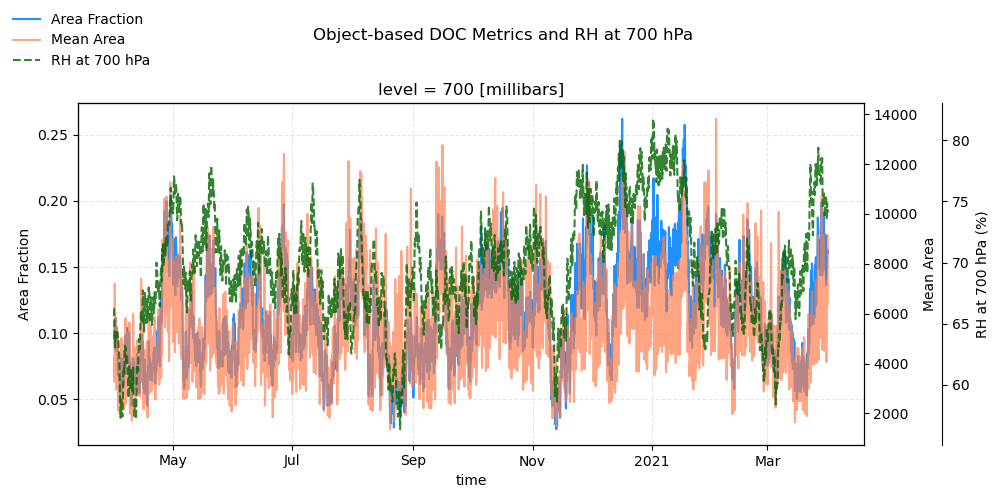

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# Left y-axis: area_frac
line1, = area_frac.plot(ax=ax, color="dodgerblue", label="Area Fraction")
ax.set_ylabel("Area Fraction")

# First right y-axis: mean_area
ax2 = ax.twinx()
line2, = mean_area.plot(ax=ax2, color="coral", alpha=0.7, label="Mean Area")
ax2.set_ylabel("Mean Area")

# Second right y-axis: r_700_3h.r
ax3 = ax.twinx()
ax3.spines['right'].set_position(('axes', 1.1))
ax3.spines['right'].set_visible(True)
line3, = r_700_3h.r.plot(ax=ax3, color="darkgreen", linestyle="--", alpha=0.8, label="RH at 700 hPa")
ax3.set_ylabel("RH at 700 hPa (%)")


lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc="upper left", frameon=False)


fig.suptitle("Object-based DOC Metrics and RH at 700 hPa", y=0.95)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


Text(0.0, 1.0, 'Object-based DOC metrics')

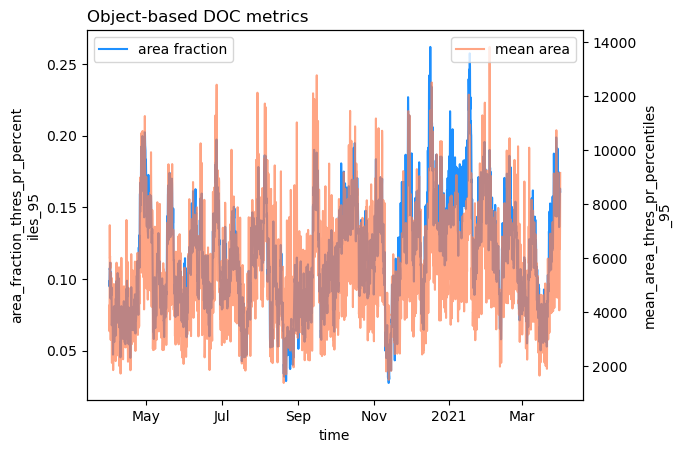

In [10]:
# Time series of metrics
fig, ax = plt.subplots()
area_frac.plot(ax = ax, c = "dodgerblue", label = "area fraction")
ax.legend(loc = 2)
ax2 = ax.twinx()
mean_area.plot(ax = ax2, c = "coral", alpha = 0.7, label = "mean area")
ax2.legend(loc = 1)
ax.set_title(f"Object-based DOC metrics", loc = "left")

In [11]:
#Daily
area_frac_daily = area_frac.resample({"time":"D"}).mean()
mean_area_daily = mean_area.resample({"time":"D"}).mean()
rh_700_daily    = r_700_3h.r.resample({"time":"D"}).mean()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


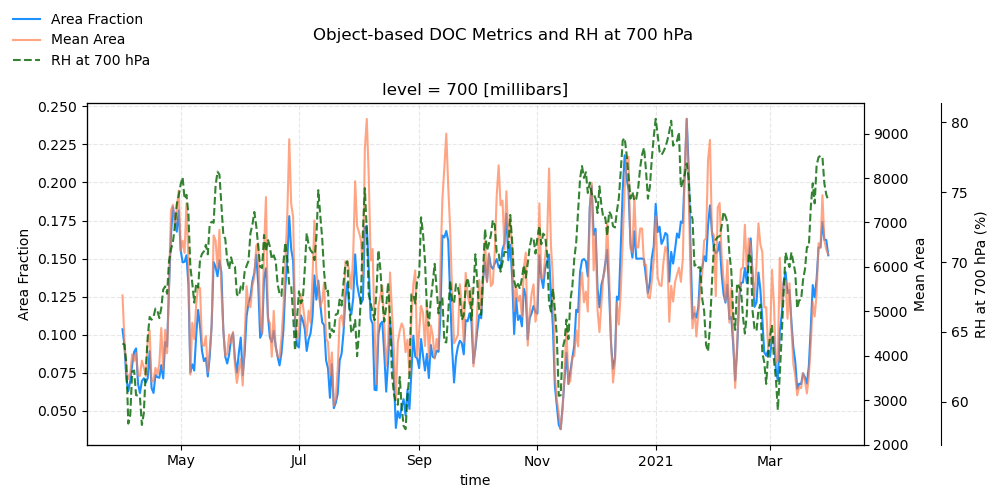

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# Left y-axis: area_frac
line1, = area_frac_daily.plot(ax=ax, color="dodgerblue", label="Area Fraction")
ax.set_ylabel("Area Fraction")

# First right y-axis: mean_area
ax2 = ax.twinx()
line2, = mean_area_daily.plot(ax=ax2, color="coral", alpha=0.7, label="Mean Area")
ax2.set_ylabel("Mean Area")

# Second right y-axis: r_700_3h.r
ax3 = ax.twinx()
ax3.spines['right'].set_position(('axes', 1.1))
ax3.spines['right'].set_visible(True)
line3, = rh_700_daily.plot(ax=ax3, color="darkgreen", linestyle="--", alpha=0.8, label="RH at 700 hPa")
ax3.set_ylabel("RH at 700 hPa (%)")


lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc="upper left", frameon=False)


fig.suptitle("Object-based DOC Metrics and RH at 700 hPa", y=0.95)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

Text(0.0, 1.0, 'Object-based DOC metrics')

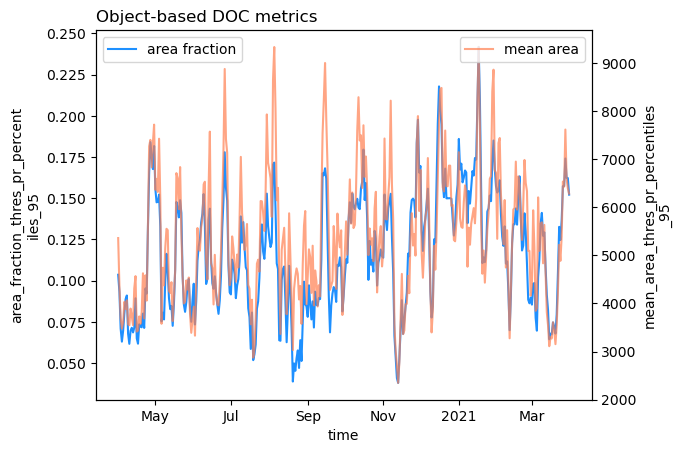

In [13]:
# Time series of metrics
fig, ax = plt.subplots()
area_frac_daily.plot(ax = ax, c = "dodgerblue", label = "area fraction")
ax.legend(loc = 2)
ax2 = ax.twinx()
mean_area_daily.plot(ax = ax2, c = "coral", alpha = 0.7, label = "mean area")
ax2.legend(loc = 1)
ax.set_title(f"Object-based DOC metrics", loc = "left")

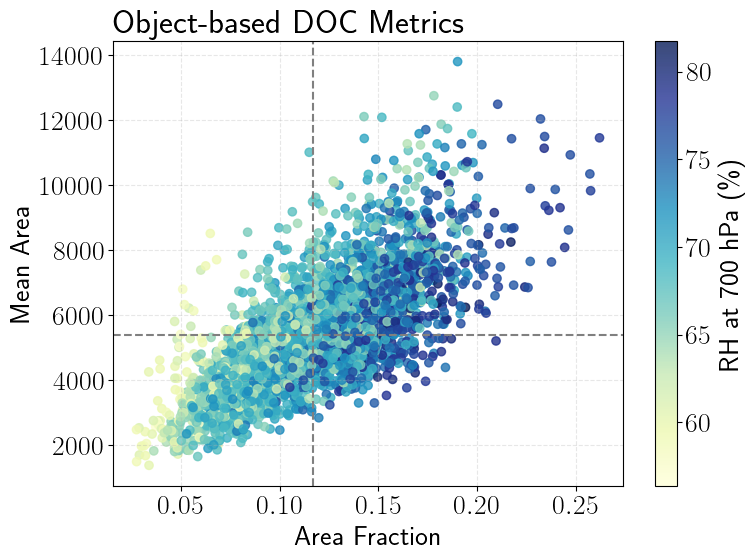

In [24]:
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.size": 20})


fig, ax = plt.subplots(figsize=(8, 6))

# Scatter with RH as color
sc = ax.scatter(area_frac, mean_area, c=r_700_3h.r, cmap="YlGnBu", alpha=0.8)

ax.axhline(y=mean_area.mean().item(), ls="--", c="grey")
ax.axvline(x=area_frac.mean().item(), ls="--", c="grey")

ax.set_xlabel("Area Fraction")
ax.set_ylabel("Mean Area")
ax.set_title("Object-based DOC Metrics", loc="left")

cb = plt.colorbar(sc, ax=ax)
cb.set_label("RH at 700 hPa (\%)")

ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


In [25]:
a = area_frac
b = mean_area
c = r_700_3h.r

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

data = pd.DataFrame({
    'area_frac': a,
    'mean_area': b,
    'r_700_3h.r': c
})



print("Correlation matrix:")
print(data.corr())


Correlation matrix:
            area_frac  mean_area  r_700_3h.r
area_frac    1.000000   0.735055    0.644649
mean_area    0.735055   1.000000    0.327039
r_700_3h.r   0.644649   0.327039    1.000000


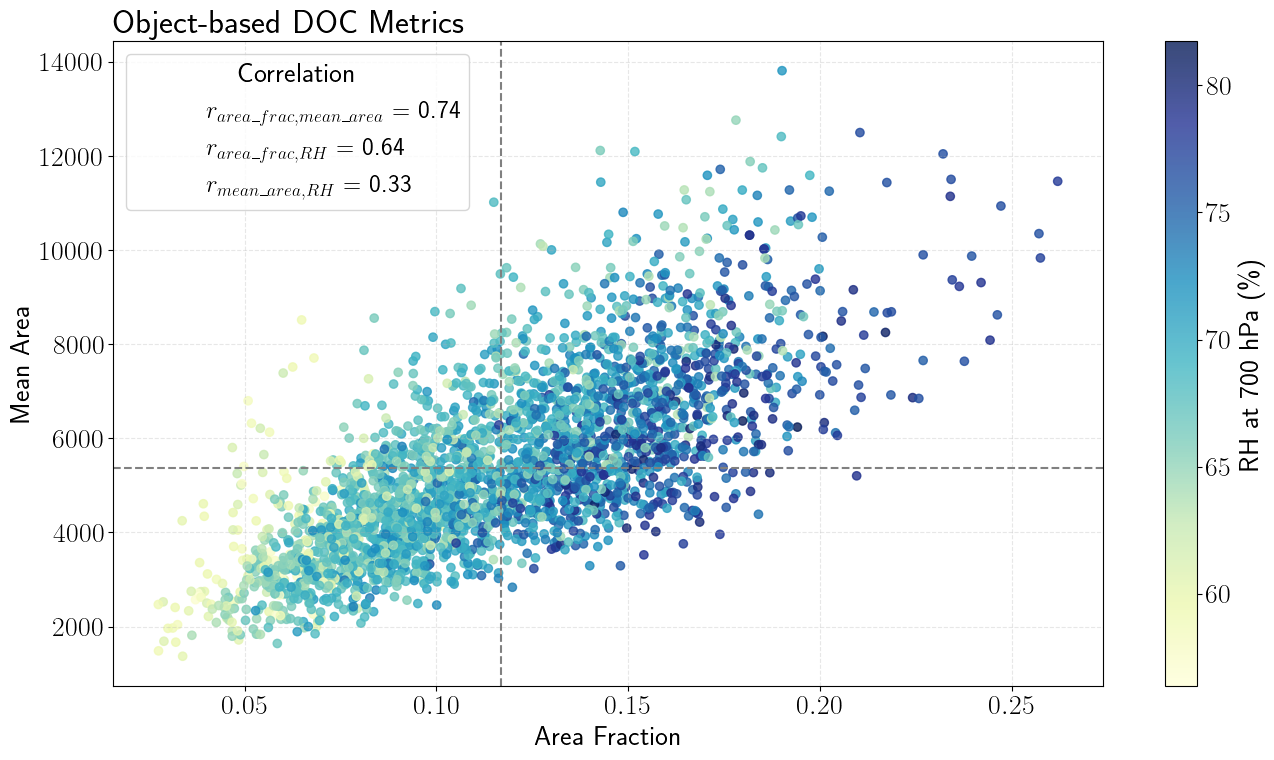

In [46]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import pandas as pd


data = pd.DataFrame({
    'area_frac': area_frac,
    'mean_area': mean_area,
    'r_700_3h.r': r_700_3h.r
})


corr_ab, _ = pearsonr(data['area_frac'], data['mean_area'])
corr_ac, _ = pearsonr(data['area_frac'], data['r_700_3h.r'])
corr_bc, _ = pearsonr(data['mean_area'], data['r_700_3h.r'])


plt.rcParams.update({"text.usetex": True, "font.size": 20})
fig, ax = plt.subplots(figsize=(14, 8))

sc = ax.scatter(data['area_frac'], data['mean_area'], c=data['r_700_3h.r'], cmap="YlGnBu", alpha=0.8)


ax.axhline(y=data['mean_area'].mean(), ls="--", c="grey")
ax.axvline(x=data['area_frac'].mean(), ls="--", c="grey")


ax.set_xlabel("Area Fraction")
ax.set_ylabel("Mean Area")
ax.set_title("Object-based DOC Metrics", loc="left")


cb = plt.colorbar(sc, ax=ax)
cb.set_label("RH at 700 hPa (\%)")


legend_elements = [
    Line2D([0], [0], linestyle='', marker='', label=fr"$r_{{area\_frac,mean\_area}}$ = {corr_ab:.2f}"),
    Line2D([0], [0], linestyle='', marker='', label=fr"$r_{{area\_frac,RH}}$ = {corr_ac:.2f}"),
    Line2D([0], [0], linestyle='', marker='', label=fr"$r_{{mean\_area,RH}}$ = {corr_bc:.2f}")
]



ax.legend(handles=legend_elements, loc='upper left', frameon=True, title='Correlation', fontsize = 18)

# Grid and layout
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


Text(0.0, 1.0, 'Object-based DOC metrics')

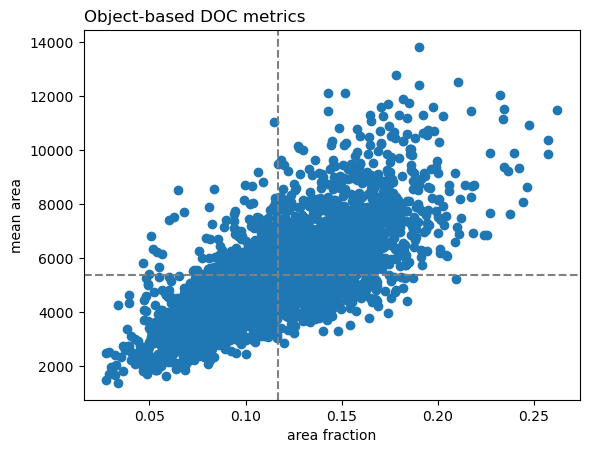

In [11]:
# Scatter plots
fig, ax = plt.subplots()
ax.scatter(area_frac, mean_area)
ax.set_ylabel( "mean area")
ax.set_xlabel( "area fraction")

ax.axhline(y = mean_area_mean, ls = "--", c = "grey")
ax.axvline(x = area_frac_mean, ls = "--", c = "grey")

ax.set_title(f"Object-based DOC metrics", loc = "left")